## PROBLEMAS COMPARACION PERIODO RETORNO DATOS NEARSHORE

Cuando Ploteo Periodos de Retorno NEARSHORE (hist vs. sim) no sale bien

En este notebook
* Series temporales interactivas con los máximos anuales


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database

p_data = r'/home/nicolas/Projects/TESLAKIT/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')

# Load HISTORICAL hourly waves for extremes analysis

# OFFSHORE
HIST_C_h = db.Load_HIST_Complete_hourly()

# NEARSHORE
HIST_N_h = db.Load_NEARSHORE_RECONSTRUCTION_HIST_hourly()


In [3]:
# --------------------------------------
# raw data files

#p_data = '/home/nicolas/Documents/data'

# historical offshore and nearshore hourly waves
#p_offshore = op.join(p_data, 'complete_hist_h.nc')
#p_nearshore = op.join(p_data, 'hourly_recon_hist.nc')

# load with xarray
#HIST_C_h = xr.open_dataset(p_offshore)
#HIST_N_h = xr.open_dataset(p_nearshore)


In [4]:
# get max. storms times from offshore hourly file
t_ms = HIST_C_h.where(HIST_C_h.max_storms==True, drop=True).time

# store max_storm data
HIST_C_ms = HIST_C_h.sel(time=t_ms)
HIST_N_ms = HIST_N_h.sel(time=t_ms)


## FIGURA INTERACTIVA DATOS HORARIOS

In [5]:

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# common fig parameters
_faspect = 1.618
_fsize = 9.8
_fdpi = 128


# develop funtion
def Plot_Interactive_Series(xds, vns, amax=''):
    
    # optional annual maxima
    xds_AMax = None
    if amax !='':
        
        # aux. func.
        def grouped_max(ds, vn=None, dim=None):
            return ds.isel(**{dim: ds[vn].argmax(dim)})
        
        # remove variable nans
        ix_nonan = np.squeeze(np.argwhere(~np.isnan(xds[amax].values[:])))
        xds_nonan = xds.isel(time = ix_nonan)

        # calculate annual maxima dataset
        xds_AMax = xds_nonan.groupby('time.year').apply(grouped_max, vn=amax, dim='time')

    # figure
    fig, axes = plt.subplots(nrows=len(vns), sharex=True, figsize=(_fsize*0.9, len(vns)*_fsize*0.28))
    
    # years locator and formater
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y/%m/%d')
    hours_fmt = mdates.DateFormatter('%Y/%m/%d - %HH')
    
    # iterate variables
    for c, v in enumerate(vns):
        
        ax = axes[c]
        
        # plot variable
        ax.plot(
            xds['time'], xds[v], 
            linestyle='-', linewidth=1, color='grey',
            #marker='.', markersize=6, markerfacecolor='black',
            label='Data',
        )
        
        # plot amax (optional)
        if xds_AMax != None:
            ax.plot(
                xds_AMax['time'], xds_AMax[v],
                linestyle='', linewidth=1, color='red',
                marker='.', markersize=6, markerfacecolor='red', markeredgecolor='red',
                label='{0} A.Max.'.format(amax)
            )
            
            for t in xds_AMax['time'].values[:]:
                ax.axvline(
                    t,
                    linestyle='-', color='red', linewidth=0.5,
                )  
            
            # mark a.max. variable label
            if amax==v:
                ax.yaxis.label.set_color('red')

        
        # customize axes
        ax.set_ylabel(v)
        ax.yaxis.tick_right()
        
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(years_fmt)

        ax.grid(which='major', axis='x',linestyle='--')
        ax.tick_params(labelsize=7)

    # customize fig
    plt.setp( axes[-1].xaxis.get_majorticklabels(), rotation=90 )
    
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower left', fontsize=8)



## Comentarios

* al hacer PAN o ZOOM apretar y mantener pulsada la tecla X para no alterar las escalas de los ejes Y 
* abajo a la derecha indica las coordenadas donde está el ratón
* para que esas coordenadas sean horarias: cambiar en la linea ax.xaxis.set_major_formatter(years_fmt) "years_fmt" por "hours_fmt"


## OFFSHORE - HOURLY

<IPython.core.display.Javascript object>


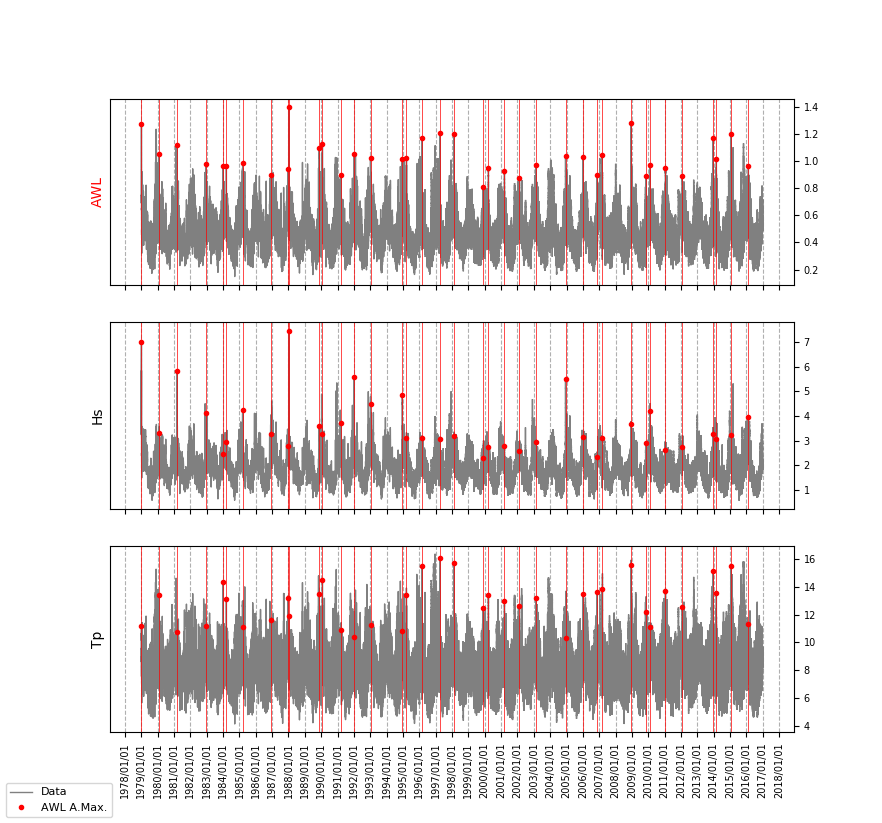

In [6]:
vars_plot = ['AWL', 'Hs', 'Tp']
var_annual_maxima = 'AWL'

# Interactive series plot
Plot_Interactive_Series(HIST_C_h, vars_plot, amax=var_annual_maxima)


## OFFSHORE - MAX STORMS

<IPython.core.display.Javascript object>


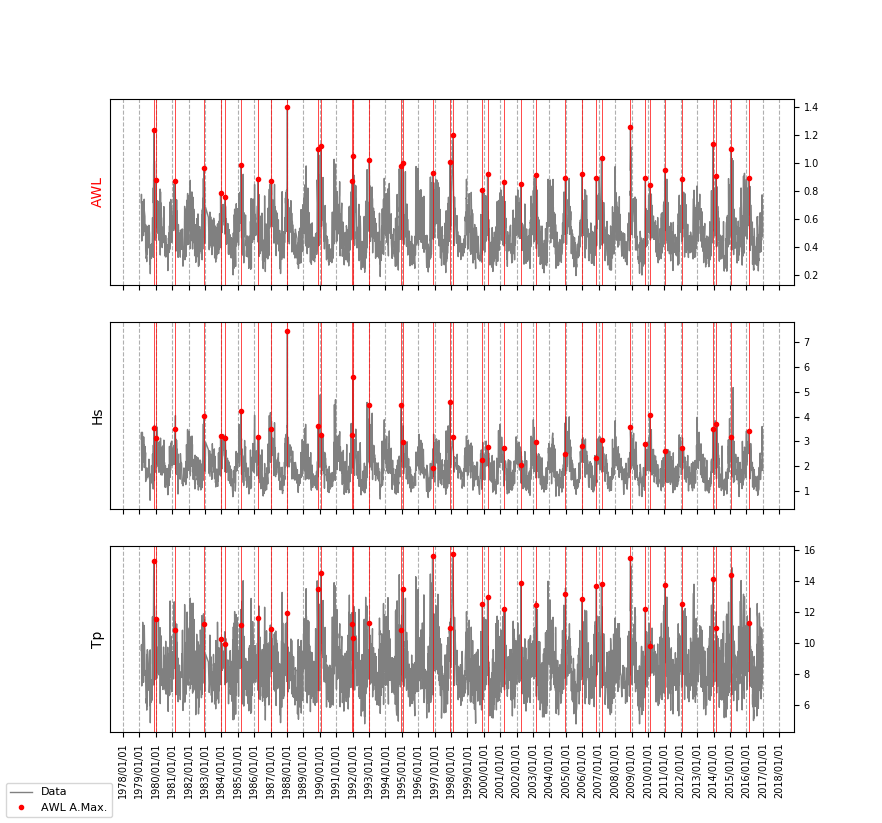

In [7]:
vars_plot = ['AWL', 'Hs', 'Tp']
var_annual_maxima = 'AWL'

# Interactive series plot
Plot_Interactive_Series(HIST_C_ms, vars_plot, amax=var_annual_maxima)

## OFFSHORE ANNUAL MAXIMA DIFERENCIAS (HORARIO - MAX_STORMS)

In [8]:
# aux. func.
def get_annual_maxima(xds, amax):
    
    def grouped_max(ds, vn=None, dim=None):
        return ds.isel(**{dim: ds[vn].argmax(dim)})
        
    # remove variable nans
    ix_nonan = np.squeeze(np.argwhere(~np.isnan(xds[amax].values[:])))
    xds_nonan = xds.isel(time = ix_nonan)

    # calculate annual maxima dataset
    xds_AMax = xds_nonan.groupby('time.year').apply(grouped_max, vn=amax, dim='time')
    
    return xds_AMax


In [9]:
amax_h = get_annual_maxima(HIST_C_h, 'AWL')
amax_ms = get_annual_maxima(HIST_C_ms, 'AWL')

print('{0}  --  {1}, {2}, {3}, {4} -- {5}'.format('year', 'H_AWL', 'H_DATE', 'MS_AWL', 'MS_DATE', 'SAME VALUE'))
print()
for y in amax_h.year:
    
    ay_h = amax_h.sel(year=y)
    ay_ms = amax_ms.sel(year=y)
    
    same =  ay_h.time.values == ay_ms.time.values
    print('{0}  --  {1:.3f}, {2}, {3:.3f}, {4} -- {5}'.format(y.values, ay_h.AWL.values, ay_h.time.values, ay_ms.AWL.values, ay_ms.time.values, same))


year  --  H_AWL, H_DATE, MS_AWL, MS_DATE -- SAME VALUE

1979  --  1.271, 1979-01-03T15:00:00.000000000, 1.235, 1979-11-27T03:00:00.000000000 -- False
1980  --  1.050, 1980-01-29T12:00:00.000000000, 0.881, 1980-01-05T00:00:00.000000000 -- False
1981  --  1.116, 1981-03-12T12:00:00.000000000, 0.873, 1981-03-09T21:00:00.000000000 -- False
1982  --  0.977, 1982-12-08T21:00:00.000000000, 0.965, 1982-12-09T00:00:00.000000000 -- False
1983  --  0.962, 1983-12-26T18:00:00.000000000, 0.789, 1983-12-14T03:00:00.000000000 -- False
1984  --  0.962, 1984-03-14T09:00:00.000000000, 0.757, 1984-03-27T00:00:00.000000000 -- False
1985  --  0.983, 1985-03-13T06:00:00.000000000, 0.983, 1985-03-13T06:00:00.000000000 -- True
1986  --  0.899, 1986-12-01T18:00:00.000000000, 0.890, 1986-03-22T06:00:00.000000000 -- False
1987  --  0.943, 1987-12-16T09:00:00.000000000, 0.875, 1987-01-05T00:00:00.000000000 -- False
1988  --  1.399, 1988-01-09T00:00:00.000000000, 1.399, 1988-01-09T00:00:00.000000000 -- True
1989  

## NEARSHORE - HOURLY

<IPython.core.display.Javascript object>


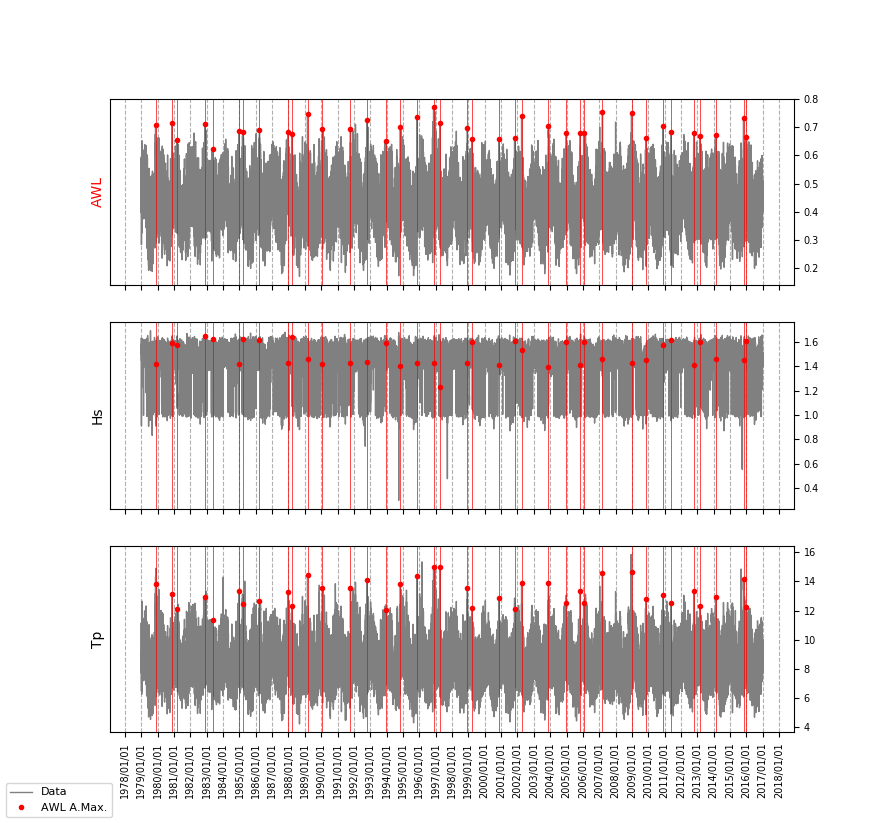

In [10]:
vars_plot = ['AWL', 'Hs', 'Tp']
var_annual_maxima = 'AWL'

# Interactive series plot
Plot_Interactive_Series(HIST_N_h, vars_plot, amax=var_annual_maxima)

## NEARSHORE - MAX STORMS

<IPython.core.display.Javascript object>


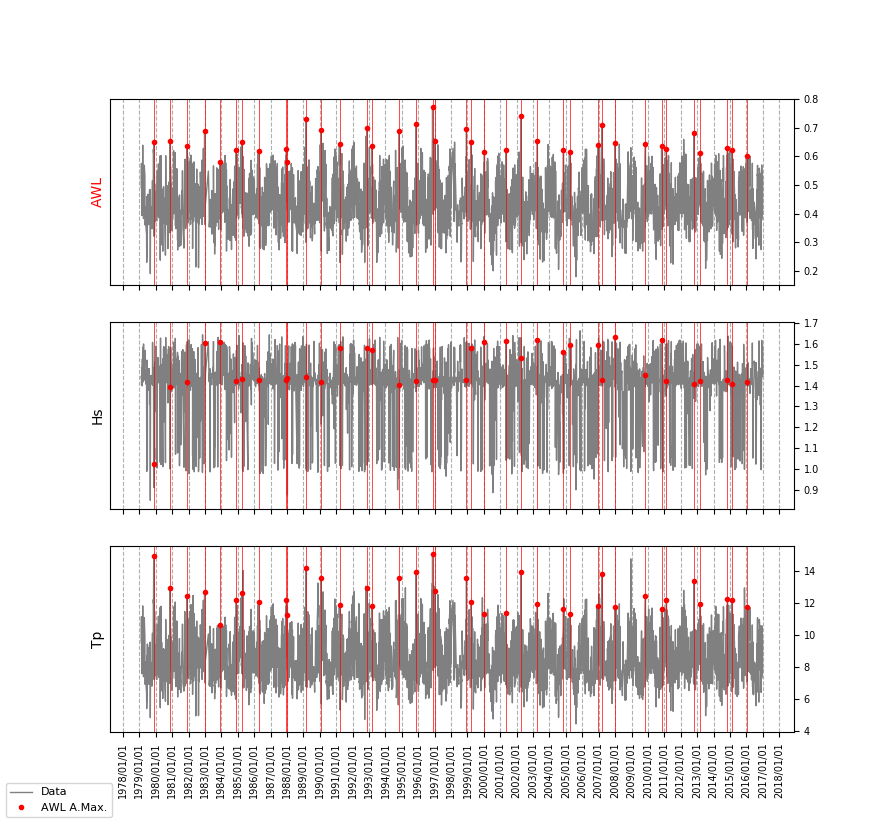

In [11]:
vars_plot = ['AWL', 'Hs', 'Tp']
var_annual_maxima = 'AWL'

# Interactive series plot
Plot_Interactive_Series(HIST_N_ms, vars_plot, amax=var_annual_maxima)

## NEARSHORE ANNUAL MAXIMA DIFERENCIAS (HORARIO - MAX_STORMS)

In [12]:
amax_h = get_annual_maxima(HIST_N_h, 'AWL')
amax_ms = get_annual_maxima(HIST_N_ms, 'AWL')

print('{0}  --  {1}, {2}, {3}, {4} -- {5}'.format('year', 'H_AWL', 'H_DATE', 'MS_AWL', 'MS_DATE', 'SAME VALUE'))
print()
for y in amax_h.year:
    
    ay_h = amax_h.sel(year=y)
    ay_ms = amax_ms.sel(year=y)
    
    same =  ay_h.time.values == ay_ms.time.values
    print('{0}  --  {1:.3f}, {2}, {3:.3f}, {4} -- {5}'.format(y.values, ay_h.AWL.values, ay_h.time.values, ay_ms.AWL.values, ay_ms.time.values, same))


year  --  H_AWL, H_DATE, MS_AWL, MS_DATE -- SAME VALUE

1979  --  0.708, 1979-11-15T15:00:00.000000000, 0.648, 1979-11-27T03:00:00.000000000 -- False
1980  --  0.714, 1980-11-16T03:00:00.000000000, 0.654, 1980-11-16T00:00:00.000000000 -- False
1981  --  0.653, 1981-03-09T03:00:00.000000000, 0.635, 1981-11-29T00:00:00.000000000 -- False
1982  --  0.712, 1982-11-26T15:00:00.000000000, 0.689, 1982-12-23T00:00:00.000000000 -- False
1983  --  0.622, 1983-05-10T06:00:00.000000000, 0.580, 1983-12-05T06:00:00.000000000 -- False
1984  --  0.685, 1984-12-19T03:00:00.000000000, 0.623, 1984-11-27T12:00:00.000000000 -- False
1985  --  0.682, 1985-03-13T21:00:00.000000000, 0.649, 1985-03-31T00:00:00.000000000 -- False
1986  --  0.690, 1986-03-24T06:00:00.000000000, 0.618, 1986-04-16T09:00:00.000000000 -- False
1987  --  0.683, 1987-12-19T21:00:00.000000000, 0.625, 1987-12-16T00:00:00.000000000 -- False
1988  --  0.676, 1988-03-15T21:00:00.000000000, 0.581, 1988-01-05T18:00:00.000000000 -- False
1989